# Vehicle Detection and Tracking

### The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Normalize features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Imports

In [1]:
import glob
import os
import shutil
import time
from collections import deque

import scipy.misc
from moviepy.video.io.VideoFileClip import VideoFileClip
from scipy.ndimage.measurements import label
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from IPython.display import HTML

from experiments import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Configuration parameters

In [2]:
test_images_fnames = [path for path in glob.iglob("test_images/test*.jpg", recursive=True)]
image_paths, images = read_images(test_images_fnames)

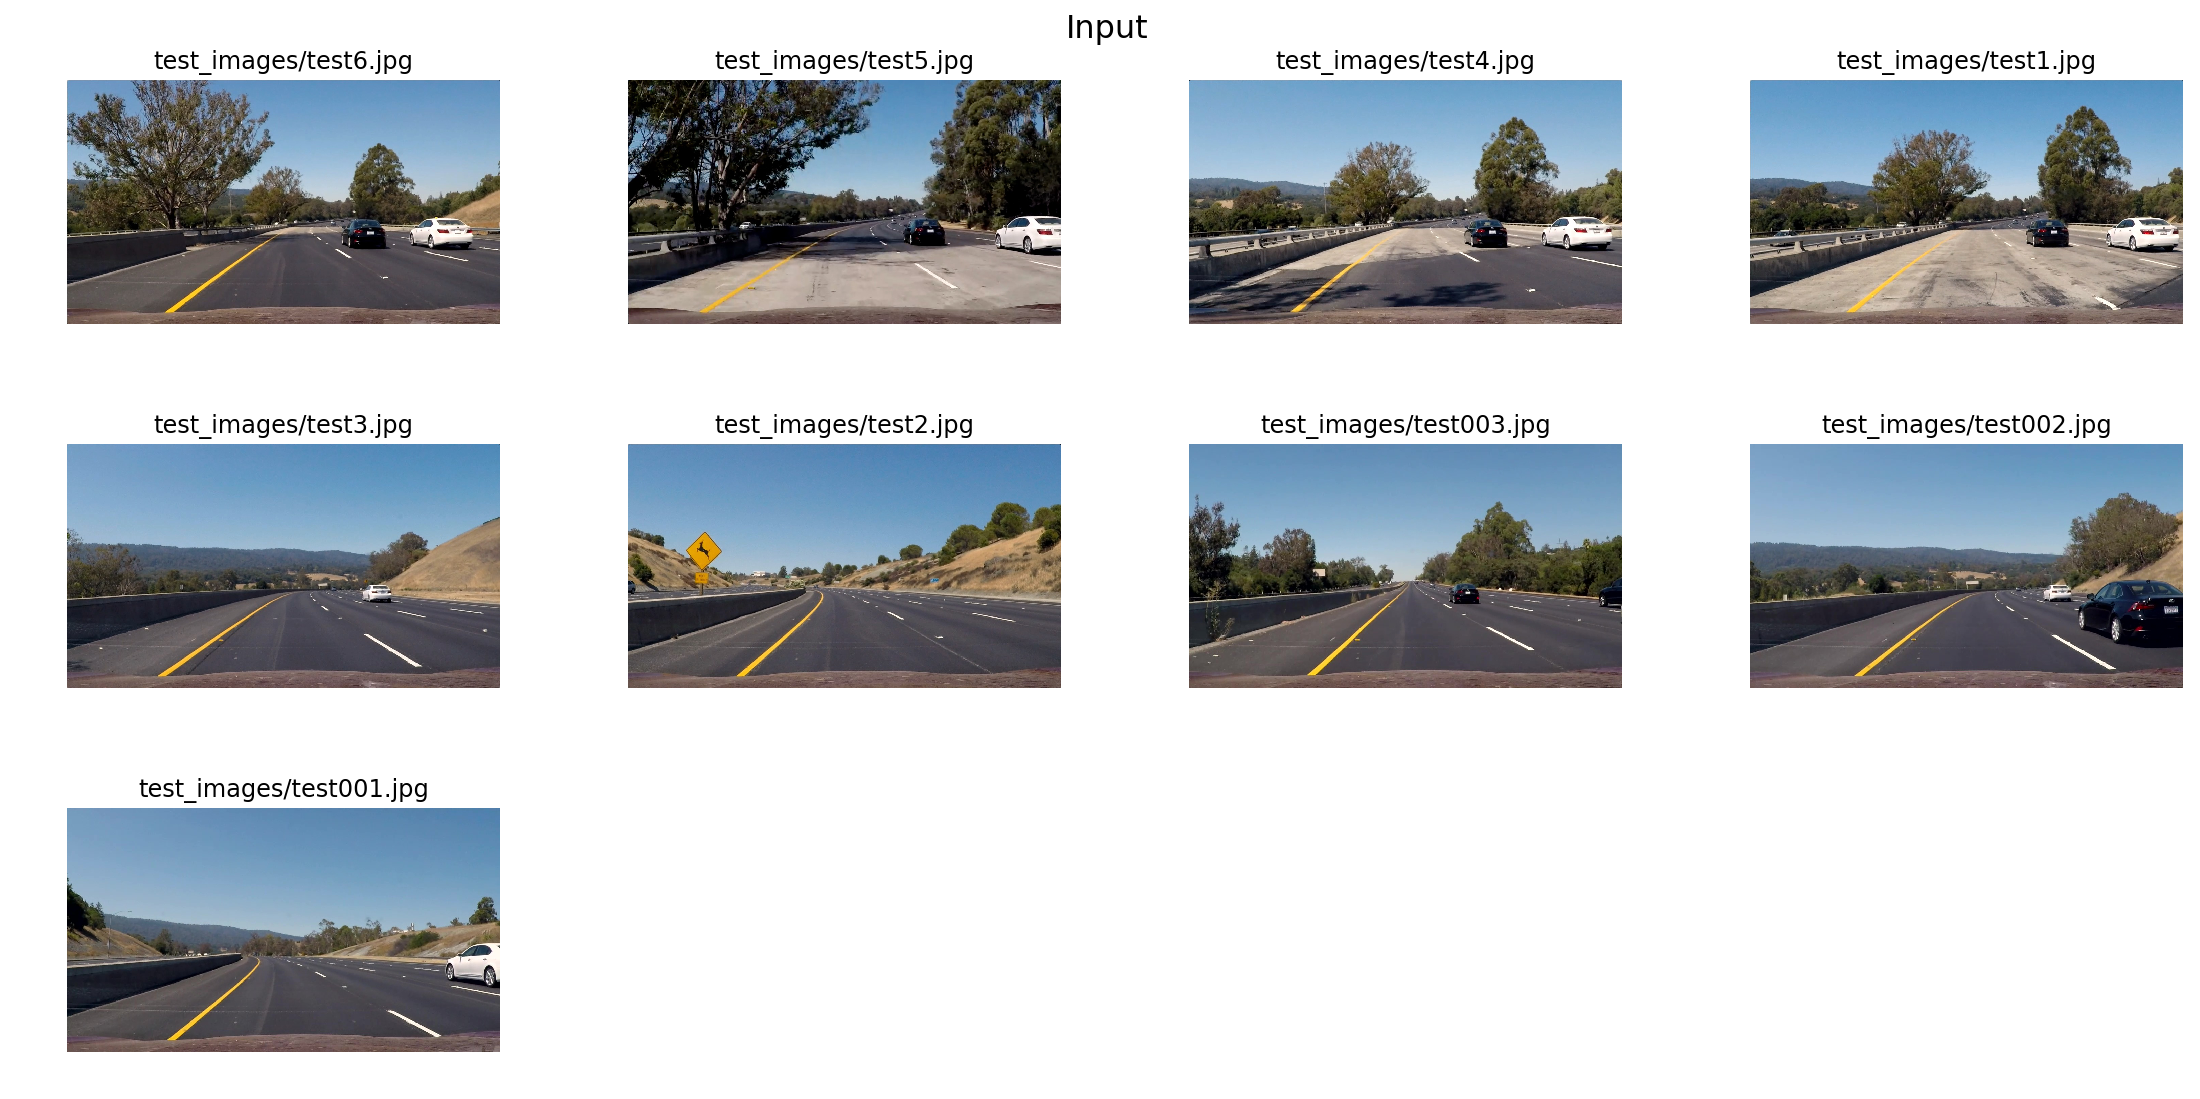

In [3]:
show_images(images, labels=image_paths, cols=len(images) // 2, title="Input")

In [4]:
vehicles_images_fnames = [path for path in glob.iglob("work/vehicles/**/*.png", recursive=True)]
vehicles_images_paths, vehicles_images = read_images(vehicles_images_fnames)

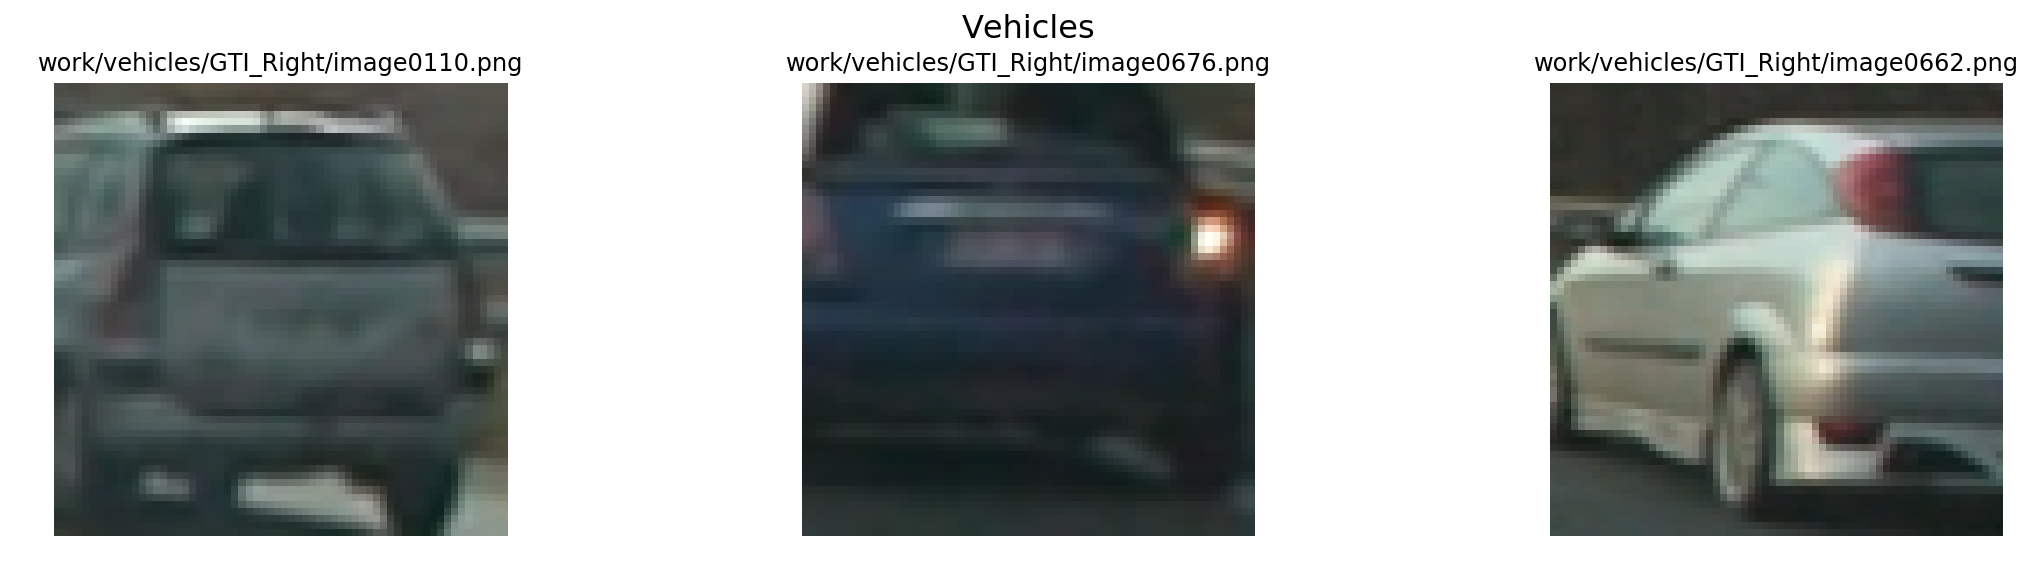

In [5]:
vehicles_images = vehicles_images[:3]
vehicles_images_paths = vehicles_images_paths[:3]
show_images(vehicles_images, labels=vehicles_images_paths, cols=len(vehicles_images), title="Vehicles")

In [6]:
nonvehicles_images_fnames = [path for path in glob.iglob("work/non-vehicles/**/*.png", recursive=True)]
nonvehicles_images_paths, nonvehicles_images = read_images(nonvehicles_images_fnames)

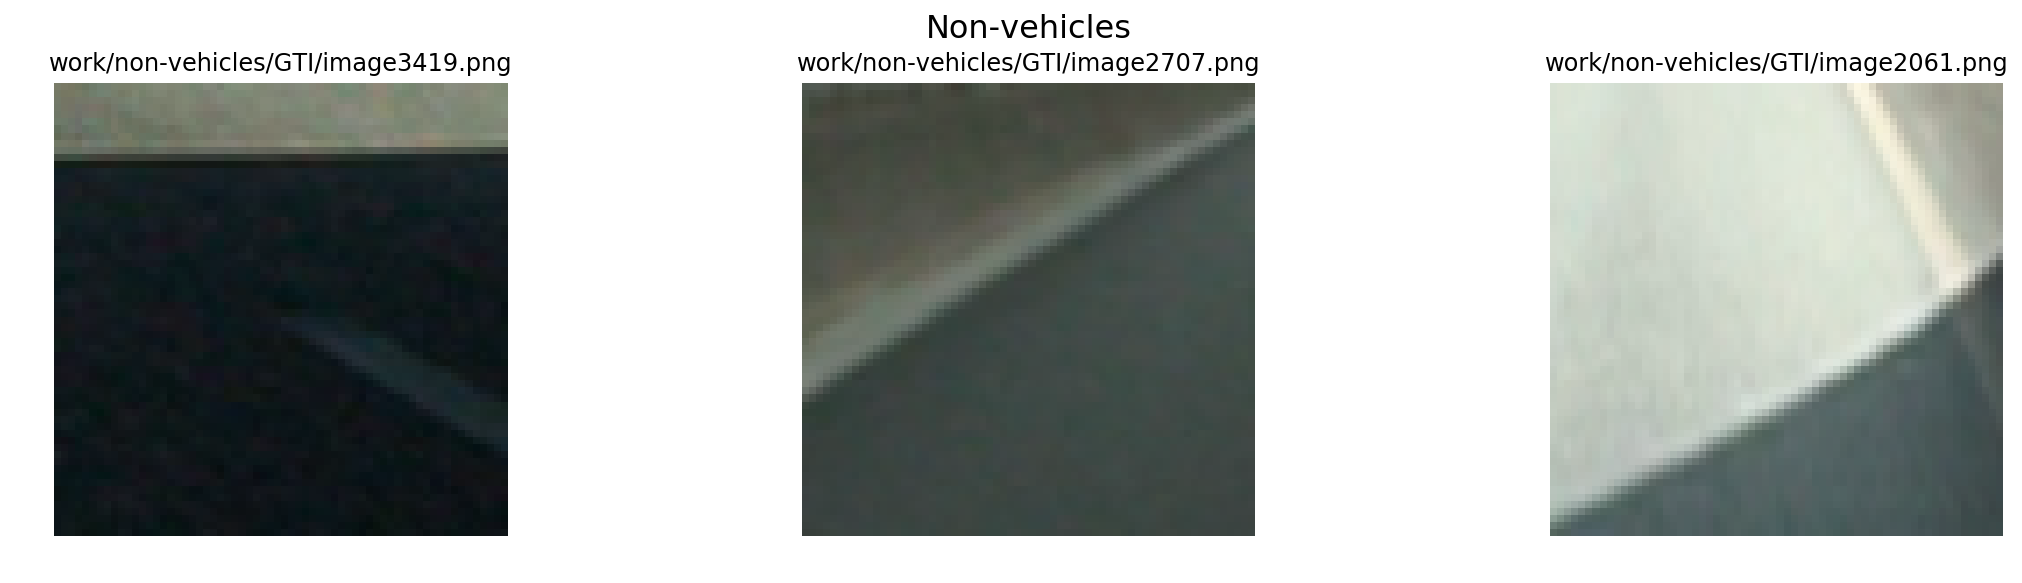

In [7]:
nonvehicles_images = nonvehicles_images[:3]
nonvehicles_images_paths = nonvehicles_images_paths[:3]
show_images(nonvehicles_images, labels=nonvehicles_images_paths, cols=len(nonvehicles_images), title="Non-vehicles")

### Visualize HOG on example image

In [8]:
vehicles_conv_images = [convert_color(image, color_space) for image in vehicles_images]
vehicles_hog_images = [convert_hog(image, hog_channel=2) for image in vehicles_conv_images]

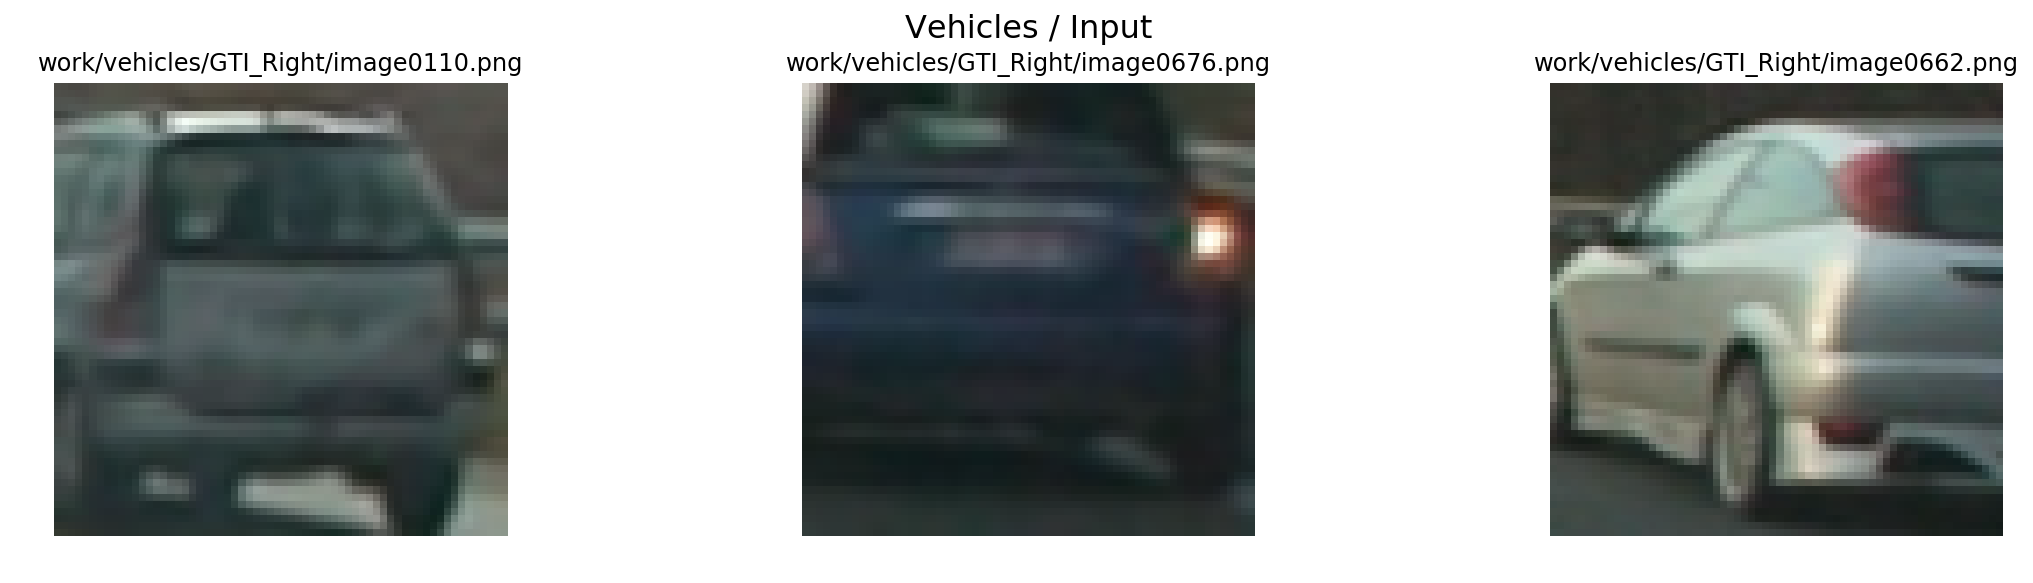

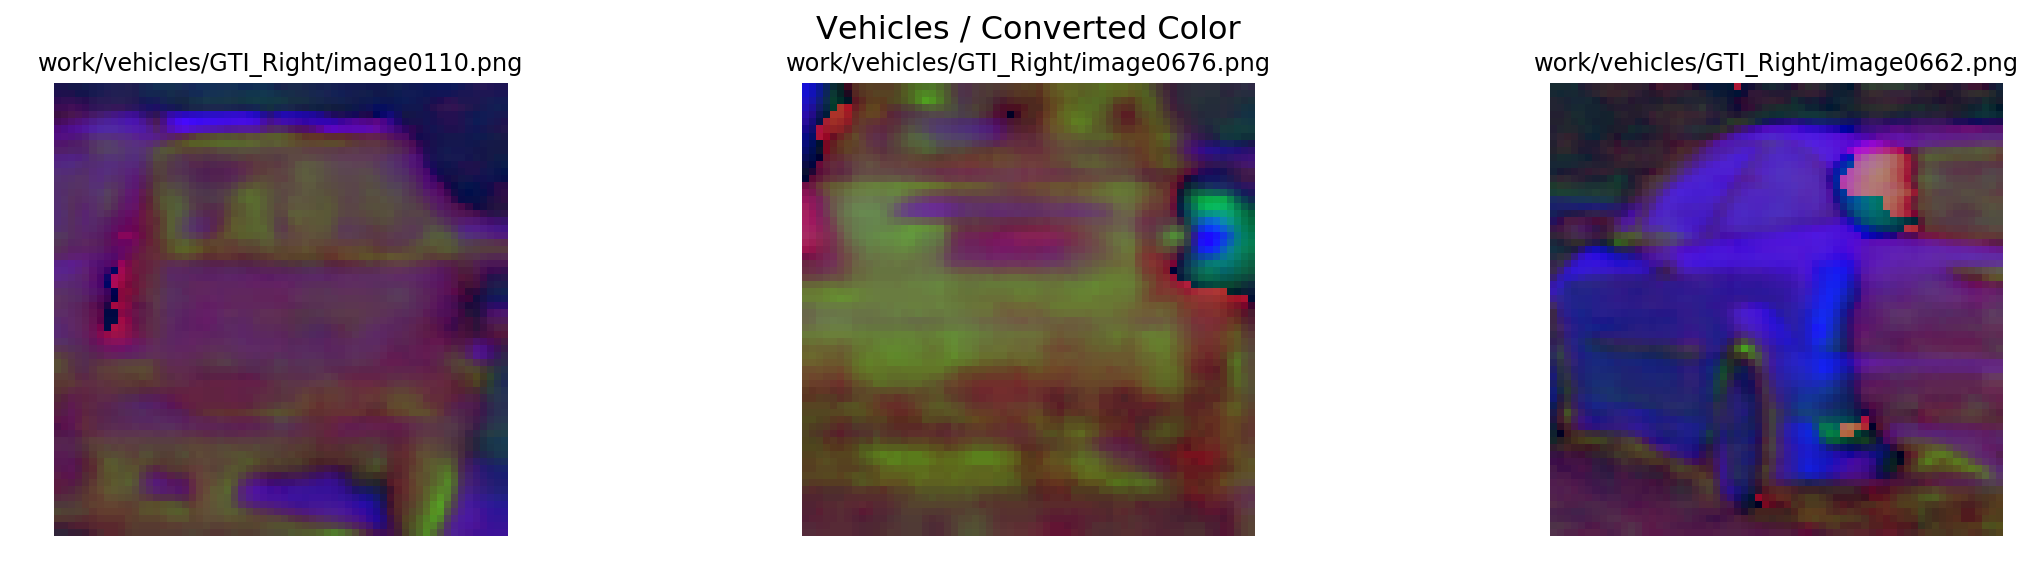

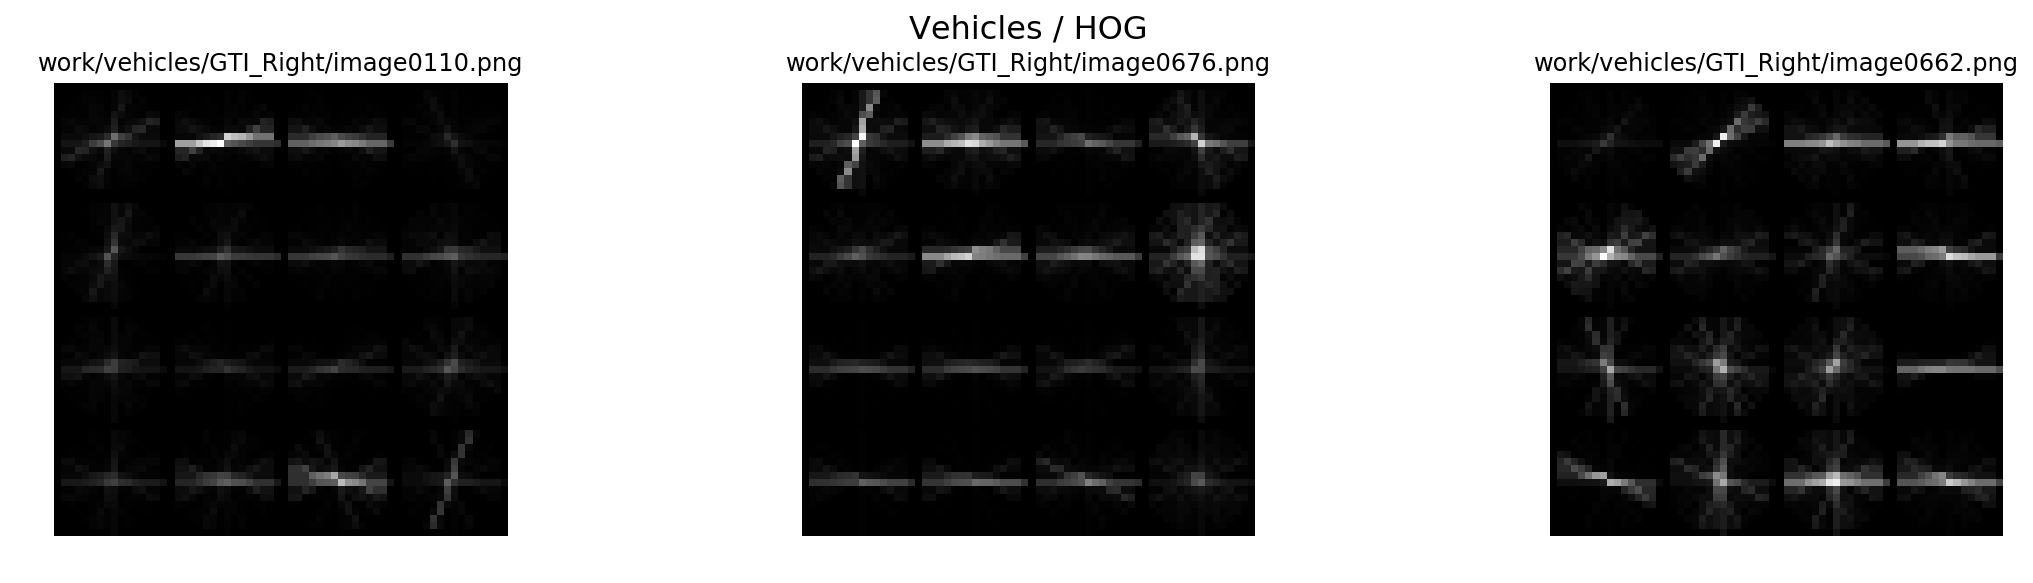

In [9]:
show_images(vehicles_images, labels=vehicles_images_paths, cols=len(vehicles_images), title="Vehicles / Input")
show_images(vehicles_conv_images, labels=vehicles_images_paths, cols=len(vehicles_conv_images), title="Vehicles / Converted Color")
show_images(vehicles_hog_images, labels=vehicles_images_paths, cols=len(vehicles_hog_images), title="Vehicles / HOG")

In [10]:
nonvehicles_conv_images = [convert_color(image, color_space) for image in nonvehicles_images]
nonvehicles_hog_images = [convert_hog(image, hog_channel=2) for image in nonvehicles_conv_images]

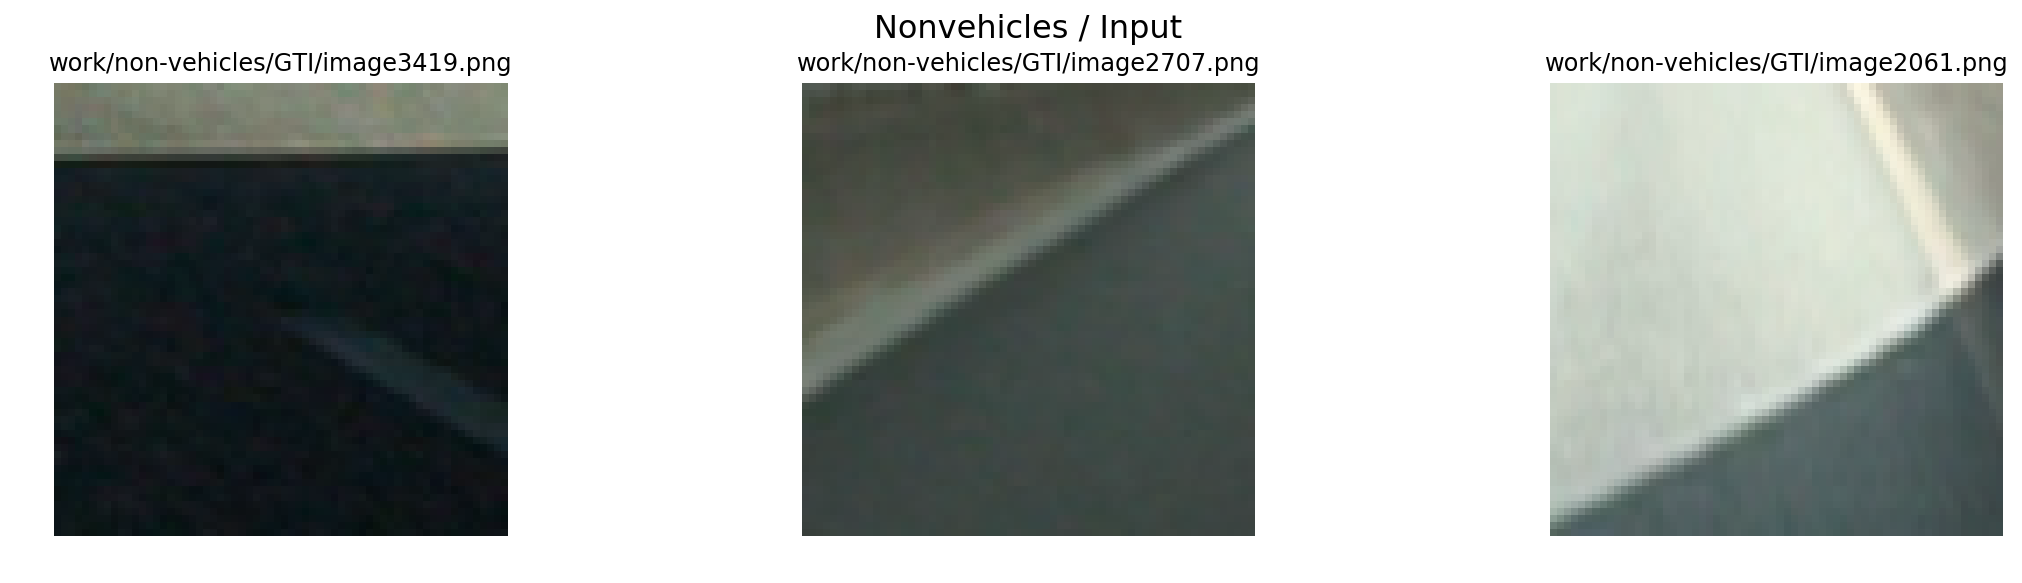

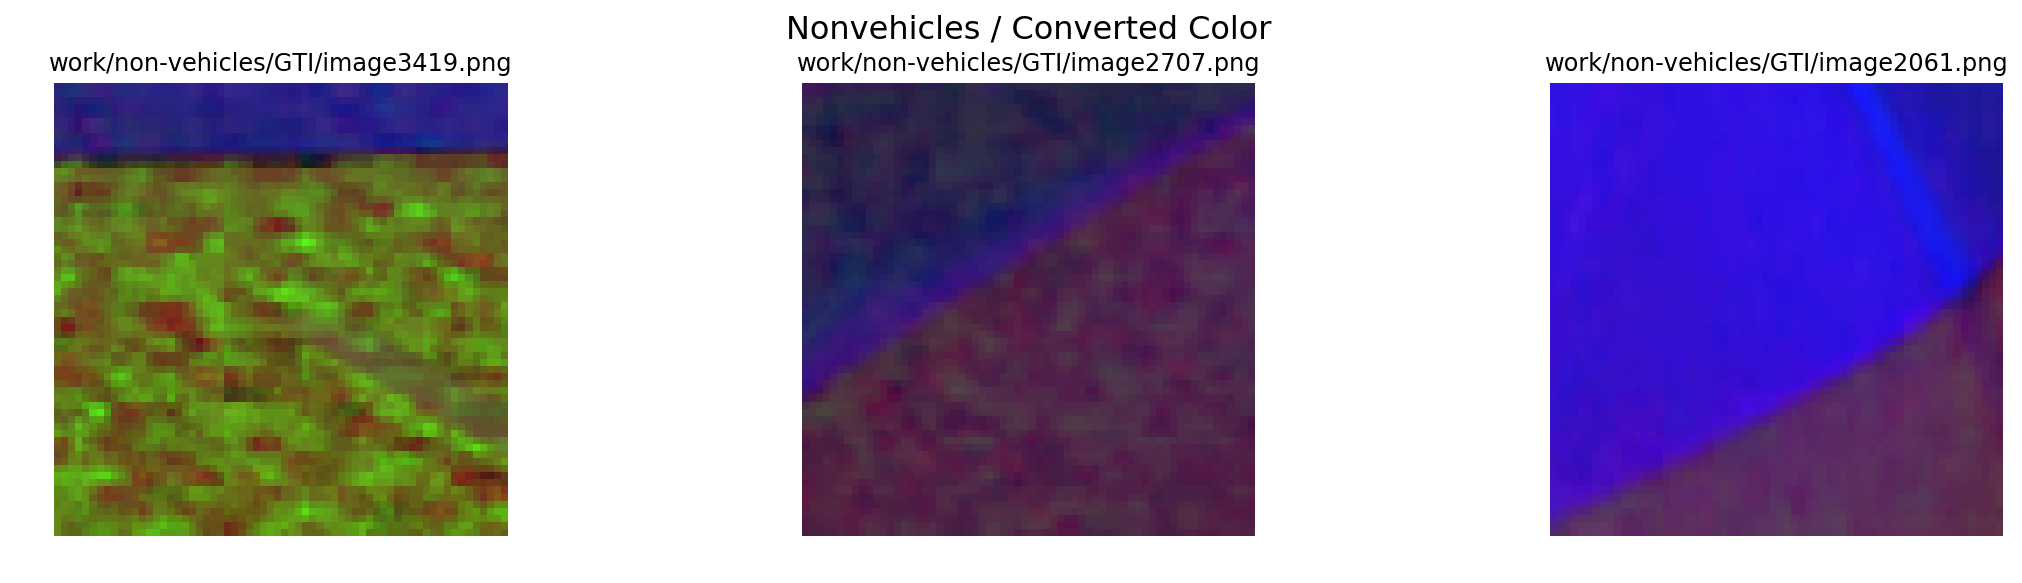

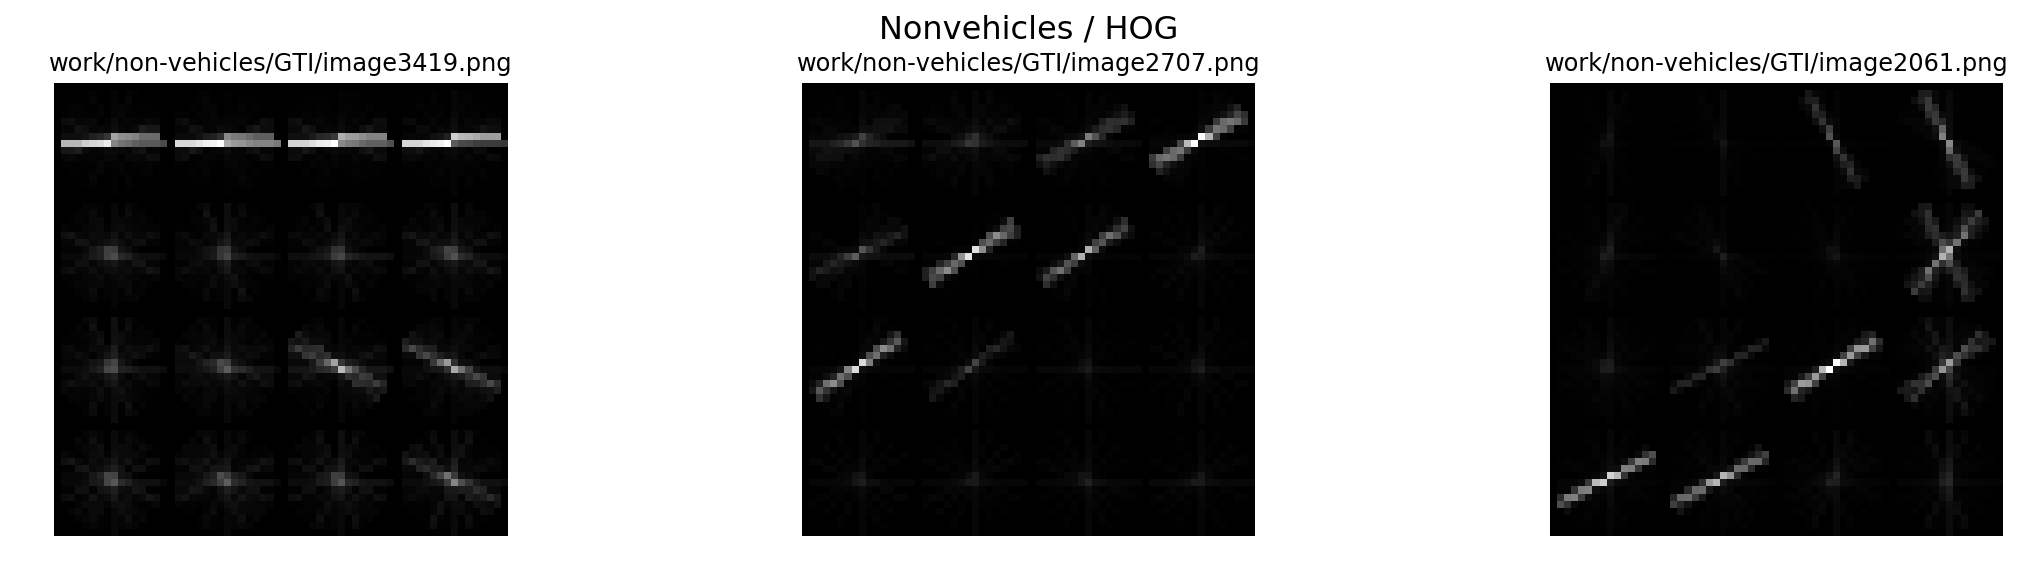

In [11]:
show_images(nonvehicles_images, labels=nonvehicles_images_paths, cols=len(nonvehicles_images), title="Nonvehicles / Input")
show_images(nonvehicles_conv_images, labels=nonvehicles_images_paths, cols=len(nonvehicles_conv_images), title="Nonvehicles / Converted Color")
show_images(nonvehicles_hog_images, labels=nonvehicles_images_paths, cols=len(nonvehicles_hog_images), title="Nonvehicles / HOG")

### Show sliding windows

In [12]:
image = images[0]
sample_image = vehicles_images[0]
print("image shape = {}".format(image.shape))
print("sample shape = {}".format(sample_image.shape))

height, width = image.shape[:2]
sample_height, sample_width = sample_image.shape[:2]
print("image: {}x{}".format(height, width))
print("sample: {}x{}".format(sample_height, sample_width))

image shape = (720, 1280, 3)
sample shape = (64, 64, 3)
image: 720x1280
sample: 64x64


In [13]:
linear_svc_path = "work/models/linear_svc_orient_%s__pix_per_cell_%s.pkl" % (orient, pix_per_cell)
standard_scaler_path = "work/models/standard_scaler_orient_%s__pix_per_cell_%s.pkl" % (orient, pix_per_cell)

In [14]:
svc, X_scaler = load_trained_model(linear_svc_path, standard_scaler_path)
print("svc = ", svc)
print("X_scaler = ", X_scaler)

svc =  LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
X_scaler =  StandardScaler(copy=True, with_mean=True, with_std=True)


In [15]:
color_configs = {}
all_slide_windows = []
for config in slide_window_config:
    top_y = config["top_y"]
    bottom_y = config["bottom_y"]
    xy_window = config["xy_window"]
    color_configs[config["xy_window"]] = config["color"]

    y_start = int(height * top_y)
    y_stop = int(height * bottom_y)

    all_slide_windows = all_slide_windows + slide_window(image, x_start_stop=[None, None],
                                                         y_start_stop=[y_start, y_stop],
                                                         xy_window=(xy_window, xy_window),
                                                         xy_overlap=(xy_overlap, xy_overlap))

In [16]:
image_slide_windows = draw_boxes(image, all_slide_windows, color_configs=color_configs)

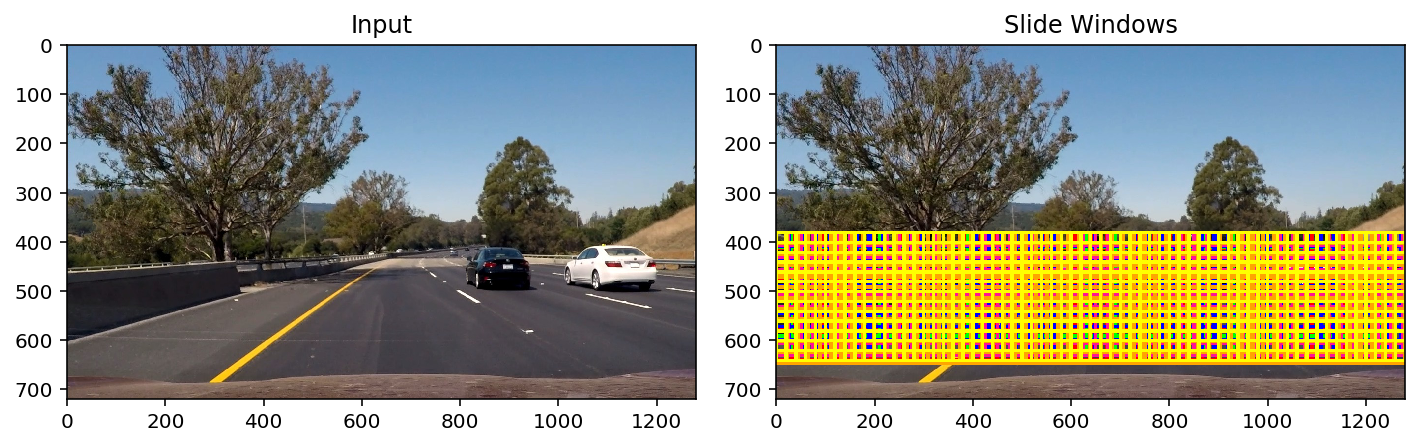

In [17]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(image)
plt.title('Input')
plt.subplot(122)
plt.imshow(image_slide_windows)
plt.title('Slide Windows')
fig.tight_layout()

In [18]:
hot_windows_lst = [search_windows(image, all_slide_windows, svc, X_scaler,
                             sample_height, sample_width, color_space,
                             spatial_size, hist_bins, hist_range, orient,
                             pix_per_cell, cell_per_block, hog_channel,
                             block_norm, transform_sqrt, vis, feature_vec,
                             spatial_feat, hist_feat, hog_feat) for image in images]

In [19]:
image_hot_windows_lst = [draw_boxes(image, found_windows, color_configs=color_configs) 
                             for image, found_windows in zip(images, hot_windows_lst)]

In [20]:
heatmap_images_lst = [group_windows(image, found_windows,
                            heatmap_threshold,
                            window_size_threshold)[0] for image, found_windows in zip(images, hot_windows_lst)]

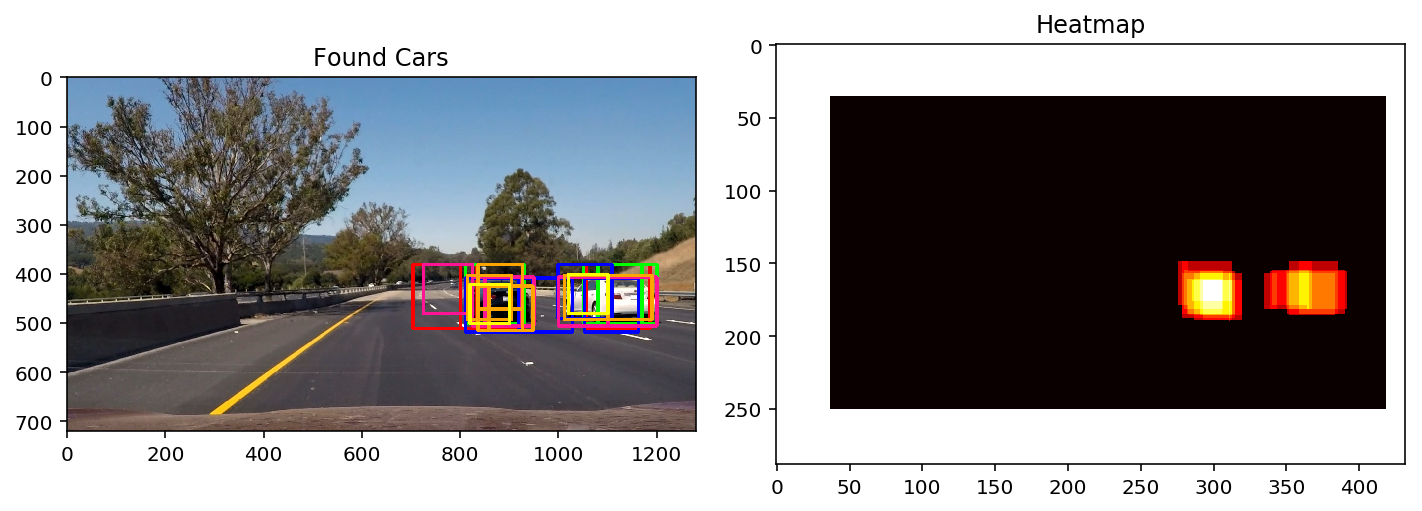

In [21]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(image_hot_windows_lst[0])
plt.title('Found Cars')
plt.subplot(122)
plt.imshow(heatmap_images_lst[0], cmap='hot')
plt.title('Heatmap')
fig.tight_layout()

In [22]:
result_images_lst = [combine_3_images(image, image_hot_windows, heatmap_images) 
                         for image, image_hot_windows, heatmap_images in zip(images, image_hot_windows_lst, heatmap_images_lst)]

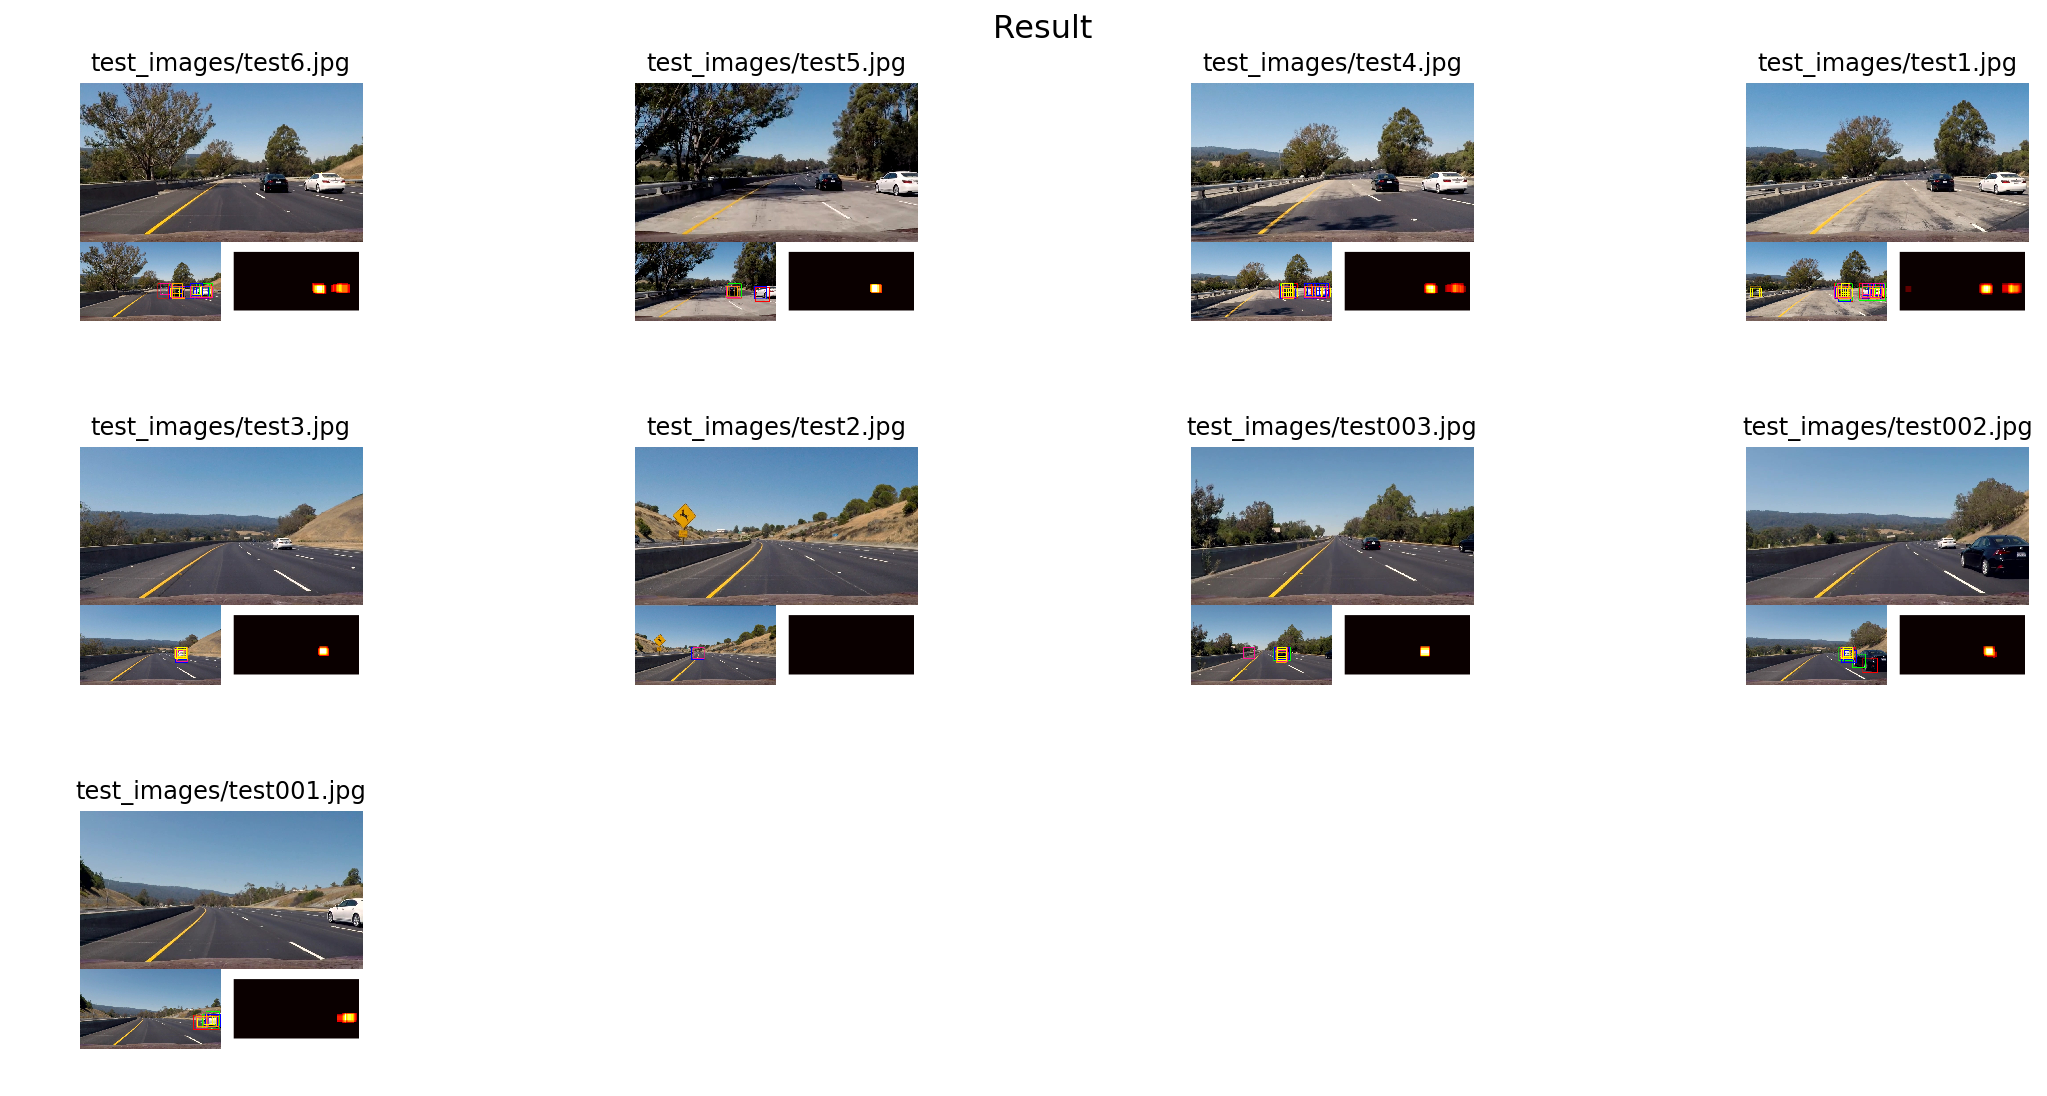

In [23]:
show_images(result_images_lst, labels=image_paths, cols=len(images) // 2, title="Result")

### Video Results

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{}">
</video>
""".format("output_images/out_project_video.mp4"))